In [1]:
import pandas as pd
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the path to the folder containing the CSV files
folder_path = 'Data/POS_daily'

# Use glob to get all CSV files in the folder
csv_files = glob.glob(f'{folder_path}/*.csv')

# Initialize an empty list to store the DataFrames
df_list = []

# Define a regular expression pattern to extract week information from filenames
pattern = re.compile(r'POS__(\d{4}-\d{2}-\d{2})')

# Loop over the list of files and read each file into a DataFrame
for file in csv_files:
    match = pattern.search(file)
    if match:
        csv_date_start = match.groups()[0]

        df = pd.read_csv(file)

        df['date'] = csv_date_start
        df['date'] = pd.to_datetime(df['date'])
        temp_year = df['date'].dt.year
        temp_week = df['date'].dt.isocalendar().week
        df['yearly_week'] = temp_year.astype(str) + '-W' + temp_week.astype(str).str.zfill(2)
        
        df_list.append(df)
    else:
        print(f"mismatch: {file}")

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(df_list)
combined_df.drop('laatst_besteld', inplace=True, axis=1)

combined_df

,gerecht,prijs_€,aantal_bestellingen,date,yearly_week
0,Frikandel,1.80,20,2021-07-01,2021-W26
1,Friet,2.00,14,2021-07-01,2021-W26
2,Friet speciaal,3.10,12,2021-07-01,2021-W26
3,Frikandel speciaal,3.00,11,2021-07-01,2021-W26
4,Friet mayonaise,2.55,8,2021-07-01,2021-W26
...,...,...,...,...,...
34,Red Bull,2.75,1,2024-04-30,2024-W18
35,Sitostick,2.80,1,2024-04-30,2024-W18
36,Speksnack,2.40,1,2024-04-30,2024-W18
37,Sundae Caramel topper,3.25,1,2024-04-30,2024-W18


In [3]:
combined_df.set_index('date', inplace=True)

start_date = combined_df.index.min()
end_date = combined_df.index.max()

print("First Date:", start_date.strftime("%Y %m %d"))
print("Last Date:", end_date.strftime("%Y %m %d"))

First Date: 2021 07 01
Last Date: 2024 04 30


In [4]:
def create_plot(index, dataframe, label="Data", xlabel="X", ylabel="Y", title=None, xlim=None, ylim=None, figsize=(12,6), legend=False):
    plt.figure(figsize=figsize)
    plt.plot(index, dataframe, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid(True)
    plt.tight_layout()
    if legend:
        plt.legend()
    plt.show()

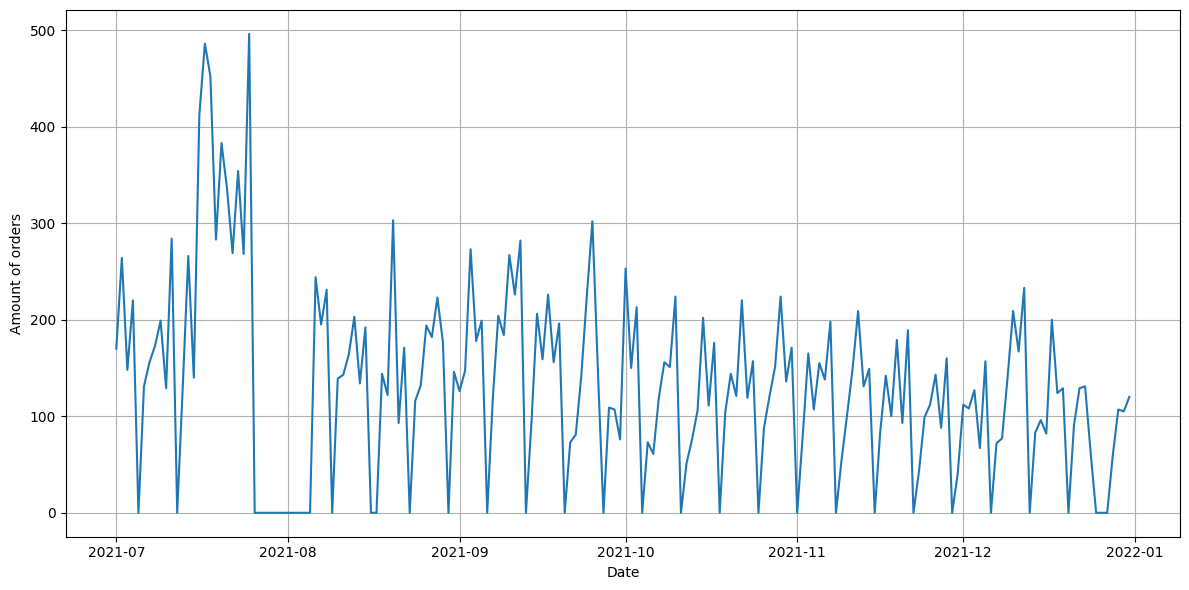

In [5]:
orders_df = combined_df.groupby(combined_df.index).apply(
    lambda x: x['aantal_bestellingen'].sum()
)

date_range = pd.date_range(start='2021-07-01', end='2021-12-31')
orders_df = orders_df.reindex(date_range, fill_value=0)

create_plot(orders_df.index, orders_df, "Amount of orders per day", "Date", "Amount of orders")

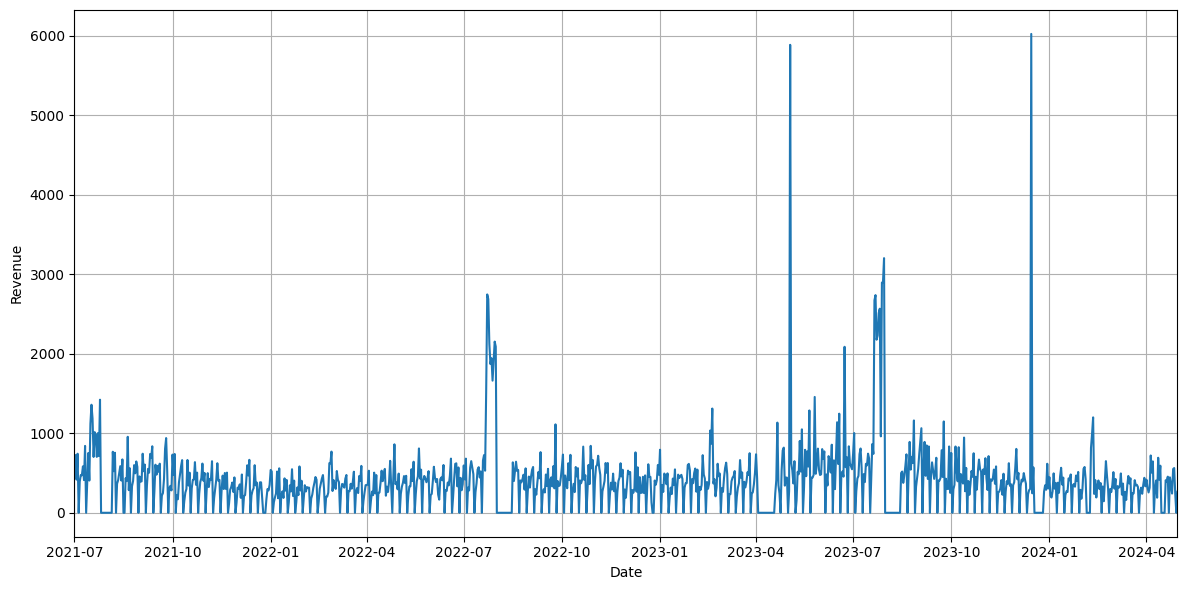

In [6]:
# Group by date and calculate the total revenue for each date
revenue_df = combined_df.groupby(combined_df.index).apply(
    lambda x: (x['prijs_€'] * x['aantal_bestellingen']).sum()
)

date_range = pd.date_range(start=start_date, end=end_date)
revenue_df = revenue_df.reindex(date_range, fill_value=0)

create_plot(revenue_df.index, revenue_df, "Revenue per day", "Date", "Revenue", xlim=(start_date, end_date))

<Axes: title={'center': 'Total revenue per day'}, xlabel='date'>

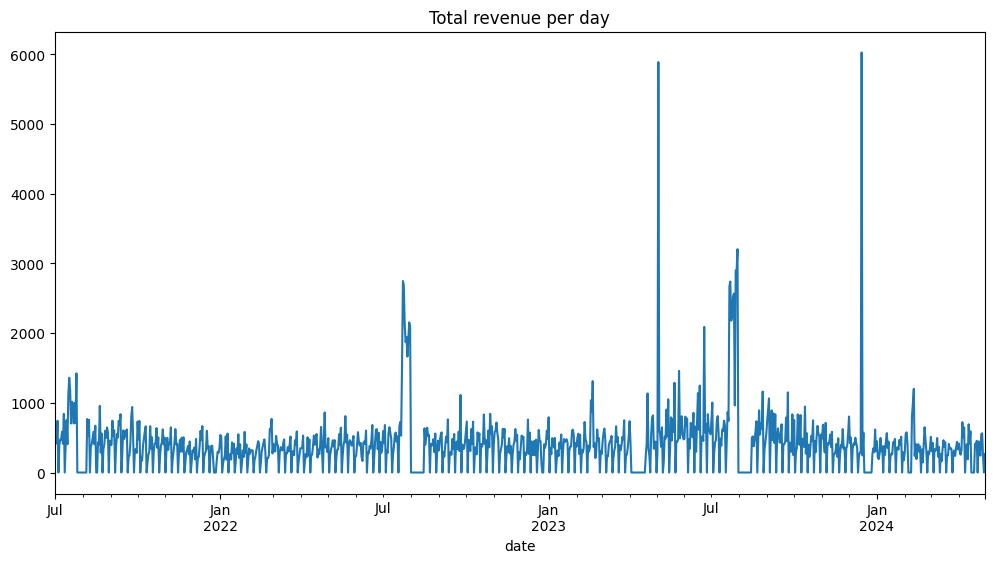

In [8]:
# Convert the resulting Series to a DataFrame and rename the columns
all_revenue = revenue_df.reset_index(name='total_revenue').rename(columns={'index': 'date'}).to_dict(orient='records')

unfilled_revenue_df = pd.DataFrame(all_revenue)

plt.figure(figsize=(12, 6))
plt.title('Total revenue per day')

unfilled_revenue_df.groupby('date')['total_revenue'].sum().plot(kind='line')

In [ ]:
date_range = pd.date_range(start='2023-12-01', end='2023-12-31')
temp = revenue_df.reindex(date_range, fill_value=0)

create_plot(temp.index, temp, "Revenue per day", "Date", "Revenue")

In [ ]:
unfilled_revenue_df.sort_values('total_revenue', ascending=False)

In [ ]:
combined_df.loc['2023-12-15']